In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [12]:
match_info = pd.read_csv("./data/match_info.csv")
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [13]:
match_info.head()

,game_id,season_id,competition_id,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,competition_name,country_name,season_name,home_team_name,home_team_name_ko,away_team_name,away_team_name_ko
0,126283,3669,587,1,2024-03-01 05:00:00,2354,4639,1,0,문수월드컵경기장,K League 1,KR,2024,Ulsan HD FC,울산 HD FC,Pohang Steelers,포항 스틸러스
1,126284,3669,587,1,2024-03-01 07:30:00,4640,4657,1,1,전주월드컵경기장,K League 1,KR,2024,Jeonbuk Hyundai Motors,전북 현대 모터스,Daejeon Hana Citizen,대전 하나 시티즌
2,126285,3669,587,1,2024-03-02 05:00:00,4648,316,2,0,광주전용구장,K League 1,KR,2024,Gwangju FC,광주FC,FC Seoul,FC서울
3,126286,3669,587,1,2024-03-02 07:30:00,4646,4220,0,1,인천축구전용경기장,K League 1,KR,2024,Incheon United,인천 유나이티드,Suwon FC,수원FC
4,126287,3669,587,1,2024-03-02 07:30:00,4643,4641,1,1,송암스포츠타운 주경기장,K League 1,KR,2024,Gangwon FC,강원FC,Jeju United,제주SK FC


In [14]:
train.head()

,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,type_name,result_name,start_x,start_y,end_x,end_y,is_home,game_episode
0,126283,1,1,0.667,2354,344559,0,Pass,Successful,52.418205,33.485444,31.322445,38.274752,True,126283_1
1,126283,1,1,3.667,2354,250036,2,Pass,Successful,32.013240,38.100808,37.371285,30.632980,True,126283_1
2,126283,1,1,4.968,2354,500145,4,Carry,NaN,37.371285,30.632980,38.391570,24.613144,True,126283_1
3,126283,1,1,8.200,2354,500145,5,Pass,Successful,38.391570,24.613144,34.573350,5.545468,True,126283_1
4,126283,1,1,11.633,2354,142106,7,Pass,Successful,34.578705,6.058256,21.274470,18.437112,True,126283_1


Y좌표 최대값: 68.0, Y좌표 최소값: 0.0
=== 팀별 전술 분석 결과 (상위 5개 팀) ===
   team_id  mean_episode_len  mean_location_x       Left     Center  Right
0      316        277.081081        47.306056  42.342342  57.657658      0
1     2353        255.652174        49.026247  40.000000  60.000000      0
2     2354        310.886792        48.863612  22.641509  77.358491      0
3     4220        273.990909        48.197363  47.272727  52.727273      0
4     4639        290.752381        46.893503  50.476190  49.523810      0


<Figure size 1200x600 with 0 Axes>

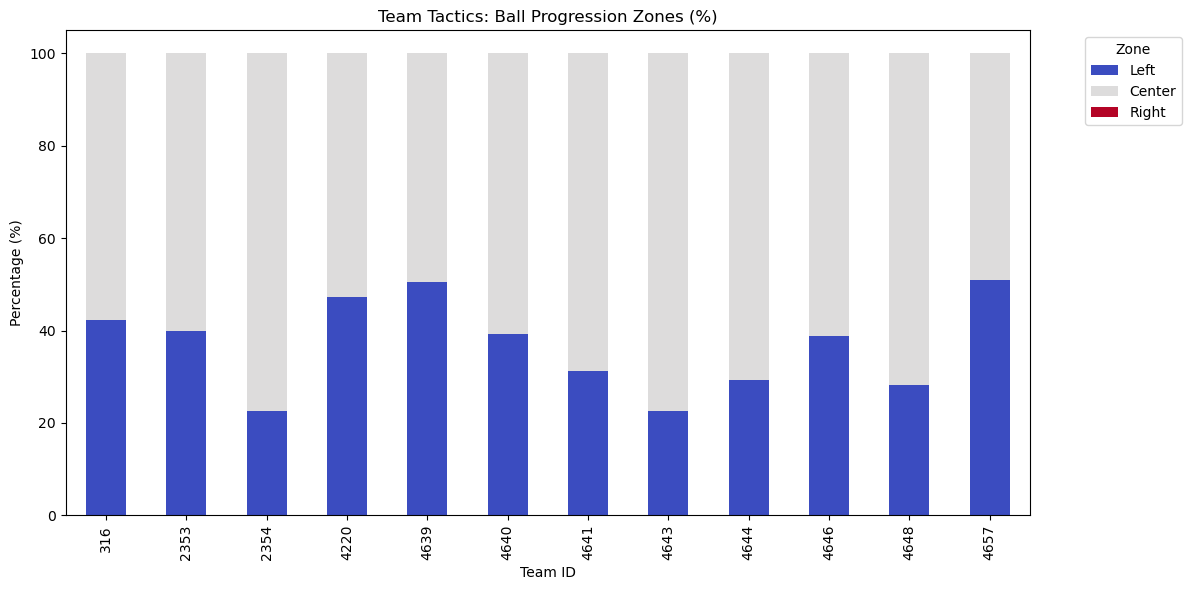

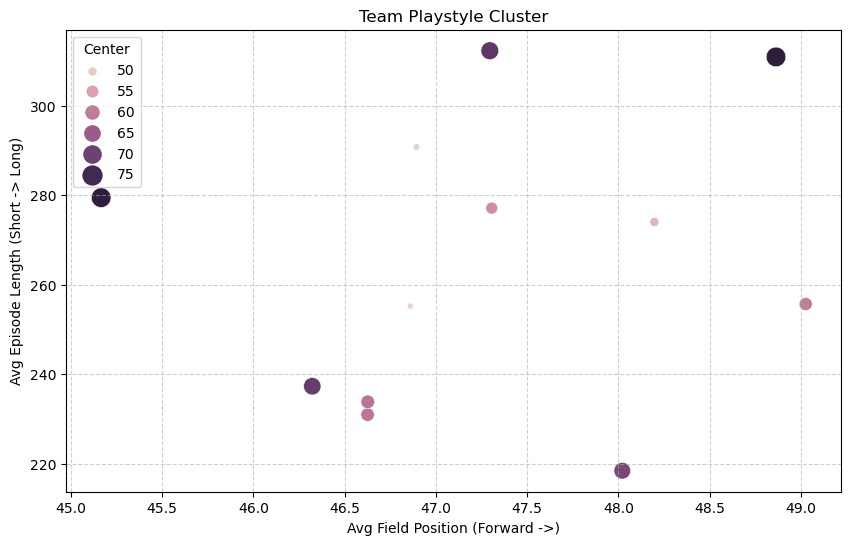

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드 (파일 경로가 맞는지 확인해주세요)
# train = pd.read_csv("./data/train.csv") # 이미 로드되어 있다면 주석 처리

# 2. 에피소드별 통계 계산
episode_stats = train.groupby(['team_id', 'episode_id']).agg(
    episode_length=('start_x', 'size'),          # 에피소드 길이 (이벤트 수)
    avg_start_x=('start_x', 'mean'),             # 평균 X 위치
    avg_start_y=('start_y', 'mean'),             # 평균 Y 위치
    avg_end_x=('end_x', 'mean'),
    avg_end_y=('end_y', 'mean')
).reset_index()

# 3. 공 전개 위치(Zone) 분류 로직 (68m 규격 기준 적용)
# 경기장 폭 68m를 3등분
# Left: 0 ~ 22.67m
# Center: 22.67 ~ 45.33m
# Right: 45.33 ~ 68m
def classify_zone(y):
    if y < 22.67:
        return 'Left'
    elif y < 45.33:
        return 'Center'
    else:
        return 'Right'

# 에피소드 평균 Y좌표 계산 및 Zone 할당
episode_stats['avg_y'] = (episode_stats['avg_start_y'] + episode_stats['avg_end_y']) / 2
episode_stats['zone'] = episode_stats['avg_y'].apply(classify_zone)

# 4. 팀별 전술 집계
# 4-1. 평균 수치 계산
team_stats = episode_stats.groupby('team_id').agg(
    mean_episode_len=('episode_length', 'mean'),  # 평균 패스/이벤트 연결 횟수
    mean_location_x=('avg_start_x', 'mean')       # 평균 라인 높이 (전진성)
)

# 4-2. Zone 비율 계산 (KeyError 방지를 위해 안전한 방식 사용)
# normalize='index'로 행별 합이 1이 되도록 계산 후 100을 곱해 %로 변환
zone_ratios = pd.crosstab(episode_stats['team_id'], episode_stats['zone'], normalize='index') * 100

# [중요] 특정 구역 데이터가 없을 경우를 대비해 컬럼을 강제로 맞춤
desired_columns = ['Left', 'Center', 'Right']
zone_ratios = zone_ratios.reindex(columns=desired_columns, fill_value=0)

# 5. 최종 데이터 병합
final_analysis = pd.merge(team_stats, zone_ratios, left_index=True, right_index=True).reset_index()

print("=== 팀별 전술 분석 결과 (상위 5개 팀) ===")
print(final_analysis.head())

# 6. 시각화
# 6-1. 팀별 공격 방향 비율 (Stacked Bar Chart)
plt.figure(figsize=(12, 6))
plot_data = final_analysis.set_index('team_id')[['Left', 'Center', 'Right']]
plot_data.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(12, 6))

plt.title("Team Tactics: Ball Progression Zones (Width=68m)")
plt.ylabel("Percentage (%)")
plt.xlabel("Team ID")
plt.legend(title='Zone', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 6-2. 팀 스타일 산점도 (Cluster Map)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=final_analysis, 
    x='mean_location_x', 
    y='mean_episode_len', 
    hue='Center', 
    size='Center', 
    sizes=(50, 300), 
    palette='viridis'
)
plt.title("Team Playstyle Analysis")
plt.xlabel("Avg Field Position (Forward ->)")
plt.ylabel("Avg Episode Length (Short -> Long)")
# 기준선 추가 (전체 평균)
plt.axvline(x=final_analysis['mean_location_x'].mean(), color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=final_analysis['mean_episode_len'].mean(), color='gray', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.legend(title='Center %', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
teams = {}
t_ids = train['team_id'].unique().tolist()
for t_id in t_ids:
    t_train = train[train['team_id'] == t_id]
    teams[t_id] = t_train

In [ ]:
teams

{2354:         game_id  period_id  episode_id  time_seconds  team_id  player_id  \
 0        126283          1           1         0.667     2354     344559   
 1        126283          1           1         3.667     2354     250036   
 2        126283          1           1         4.968     2354     500145   
 3        126283          1           1         8.200     2354     500145   
 4        126283          1           1        11.633     2354     142106   
 ...         ...        ...         ...           ...      ...        ...   
 347924   126475          2          91      3031.733     2354     500145   
 347928   126475          2          91      3036.233     2354     250036   
 347929   126475          2          91      3036.233     2354     250036   
 347931   126475          2          92      3057.700     2354     150850   
 347932   126475          2          92      3057.700     2354     150850   
 
         action_id     type_name   result_name    start_x    start_y